## Imports

In [3]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


## Import utility functions

In [4]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [5]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
NUM_EPOCHS = 100

Device: cuda:0


In [6]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## 1. ETL (Extract, Transform, Load)

In [7]:
df = pd.read_csv('datasets/selected_500user.csv')
df

,MeterID,DATE-Time,KWH
0,6200093839,2021-01-01 00:00:00,0.602
1,6200093839,2021-01-01 00:15:00,0.589
2,6200093839,2021-01-01 00:30:00,0.410
3,6200093839,2021-01-01 00:45:00,0.495
4,6200093839,2021-01-01 01:00:00,0.450
...,...,...,...
16967640,6200091271,2021-12-31 22:45:00,1.323
16967641,6200091271,2021-12-31 23:00:00,1.327
16967642,6200091271,2021-12-31 23:15:00,1.321
16967643,6200091271,2021-12-31 23:30:00,1.311


## 2. EDA (Exploratory Data Analysis)

In [8]:
# Updated
def clean_data(df, user_id):
    # Get unique MeterID values
    unique_meter_ids = df['MeterID'].unique()

    # Create a new list of user IDs as strings
    user_ids = [str(i) for i in range(len(unique_meter_ids))]

    # Create a dictionary that maps each unique MeterID value to a unique user ID
    user_id_dict = {meter_id: user_id for meter_id, user_id in zip(unique_meter_ids, user_ids)}

    # Create a new column "user" that maps each MeterID value to a user ID
    df["user"] = df["MeterID"].apply(lambda x: user_id_dict[x])

    # Select the data for the specified user
    user_data = df[df['user']==str(user_id)]

    # Drop not useful columns
    user_data['DATE-Time'] = pd.to_datetime(user_data['DATE-Time'], infer_datetime_format=True)
    user_data.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_data = user_data.set_index('DATE-Time').resample("15T").mean()
    
    # Convert the index to a DatetimeIndex object
    user_data.index = pd.to_datetime(user_data.index)

    # Count the number of zero values in each day
    zero_counts = user_data.groupby(user_data.index.floor('D'))['KWH'].apply(lambda x: (x == 0).sum())

    # Get the dates where the number of zero values is less than or equal to 48
    valid_dates = zero_counts[zero_counts <= 48].index

    # Drop the dates where the number of zero values is greater than 48
    user_data = user_data[user_data.index.floor('D').isin(valid_dates)]

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_data.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_data_clean = user_data[~user_data.index.to_series().dt.date.isin(missing_dates)]
    
    if user_data_clean.empty:
        return None

    return user_data_clean

In [9]:
def clean_multiple_users(df, num_users):
    # Create a list of user IDs to clean
    user_ids = range(num_users)

    # Call the clean_data() function for each user ID and concatenate the results
    all_users_clean = pd.concat([clean_data(df, user_id) for user_id in user_ids], axis=0)

    return all_users_clean

In [10]:
all_users_clean = clean_multiple_users(df, 101)
all_users_clean

,KWH
DATE-Time,
2021-01-01 00:00:00,0.602
2021-01-01 00:15:00,0.589
2021-01-01 00:30:00,0.410
2021-01-01 00:45:00,0.495
2021-01-01 01:00:00,0.450
...,...
2021-12-31 22:45:00,0.010
2021-12-31 23:00:00,0.002
2021-12-31 23:15:00,0.010


In [18]:
# user_6 = clean_data(df, 6)
# user_6

In [19]:
# plt.figure(figsize=(12,4))
# plt.title('(Energy Consumptions)', size=15)
# plt.ylabel('KWH')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# plt.plot(user_6['KWH'])
# plt.show()

## 3. Prepare the data

In [20]:
def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    windowed_data = np.reshape(data, (num_windows, window_size))
    
    return windowed_data

# Example usage
window_size = 96
data = all_users_clean.to_numpy()
windowed_data = create_windowed_dataset(data, window_size)
print(f" Window shape : {windowed_data.shape}")
print(f" Type of Window : {type(windowed_data)}")

 Window shape : (31437, 96)
 Type of Window : <class 'numpy.ndarray'>


The shape of the dataset (for selected `User_1`) is `(329, 96)` which means: 
* we have `329` samples `(i.e., 329 non-overlapping windows)`,
* each window has `96` time steps `(i.e., 96 data points)`,
* and `1` feature `(i.e., KWH)`.

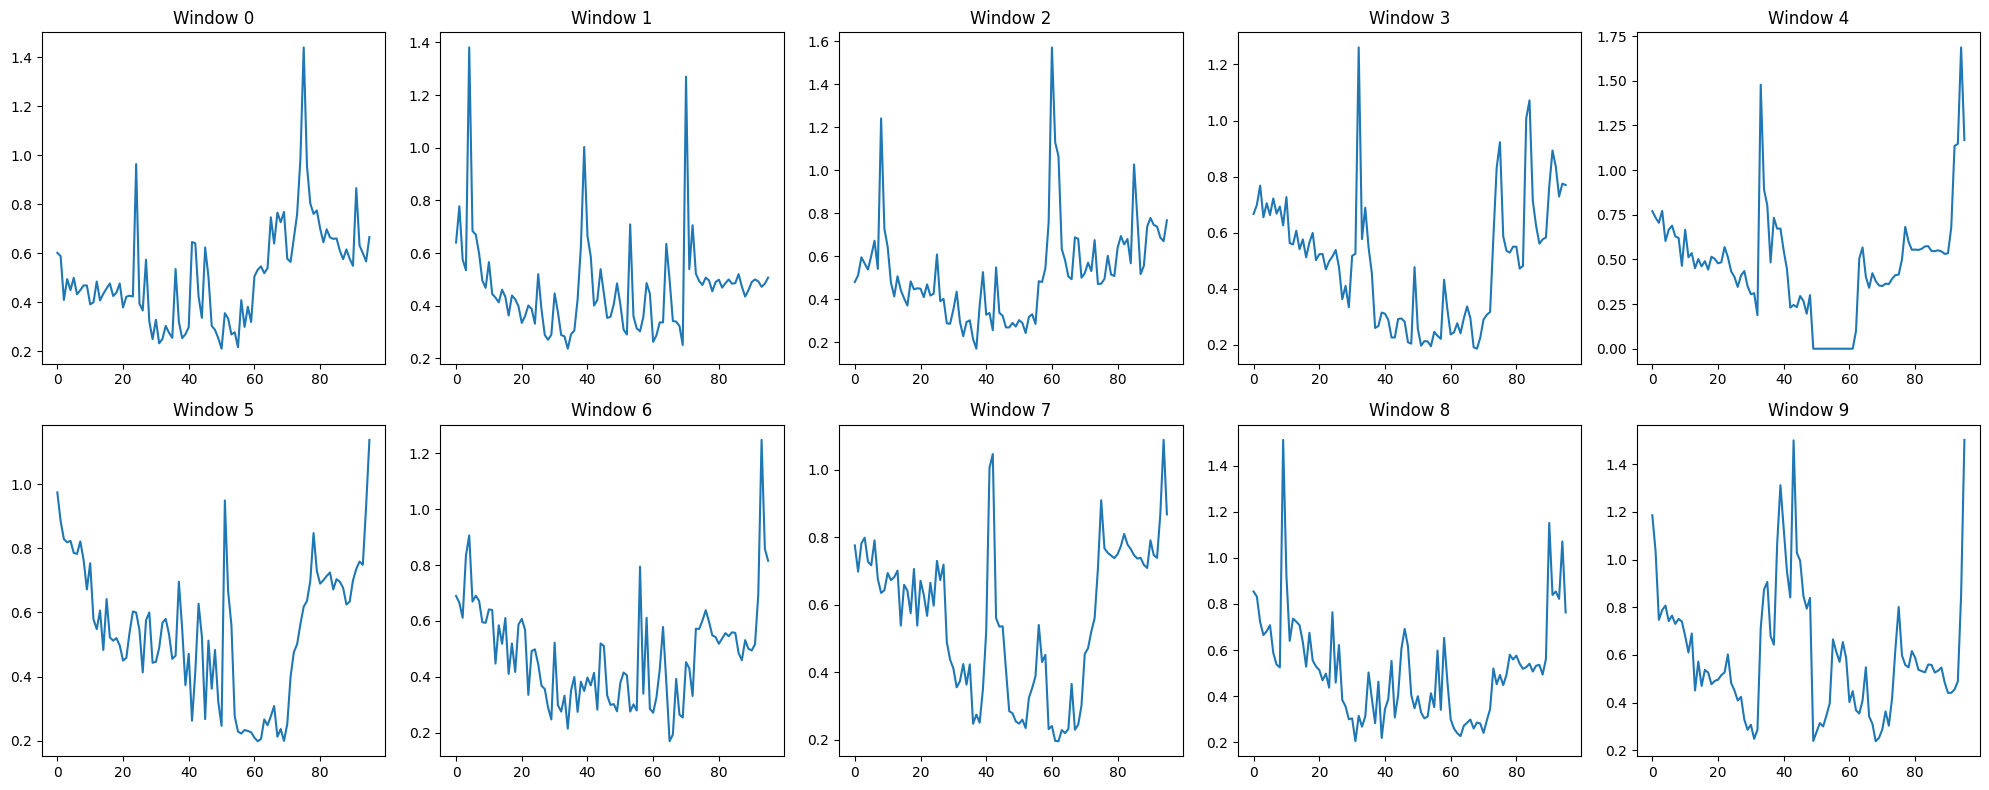

In [21]:
# Plot the first 10 windows
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.plot(windowed_data[i])
    ax.set_title(f"Window {i}")
plt.tight_layout()
plt.show()

### Divide the data into train, validation, and test sets

`train_data_tensor[:-1]` and `train_data_tensor[1:]` are indexing operations on the `train_data_tensor` PyTorch tensor.

`train_data_tensor[:-1]` means all elements of `train_data_tensor` except for the last one. 
* This is because in the context of the autoencoder model, we will be predicting the next time step based on the current time step, so the last element of train_data_tensor cannot be used as a predictor.

`train_data_tensor[1:]` means all elements of `train_data_tensor` except for the first one. 
* This is because in the context of the autoencoder model, we will be training the model to predict the next time step given the current time step, so the first element of train_data_tensor cannot be used as a prediction target.

In summary, `train_dataset` contains tuples of `input` and `target` data, where the input data is `train_data_tensor[:-1]` and the target data is `train_data_tensor[1:]`.

We'll split the examples into train, validation and test sets:

In [22]:
# Divide the data into training, validation, and test sets 
train_data, val_data = train_test_split(windowed_data, test_size=0.10, shuffle=True, random_state=RANDOM_SEED)
val_data, test_data = train_test_split(val_data, test_size=0.5, shuffle=True, random_state=RANDOM_SEED)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(28293, 96)
(1572, 96)
(1572, 96)


We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [23]:
def create_dataset(df):
    sequences = df.astype(np.float32).tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (96x1 in our case).

Let's create some datasets:

In [24]:
train_dataset, seq_len, n_features = create_dataset(train_data)
val_dataset, _, _ = create_dataset(val_data)
test_normal_dataset, _, _ = create_dataset(test_data)

### 4. Define the model

This model takes in a tensor of shape `(batch_size, sequence_length, num_features)` as input and outputs a tensor of the same shape. 

We use `Conv1d` layers for the encoder and `ConvTranspose1d` layers for the decoder.

Note that the number of input channels for the first Conv1d layer is 1, because we are using a univariate time series as input. 

If you had a multivariate time series, you would set the number of input channels to the number of features in your data.

You can adjust the number of channels and the kernel sizes of the convolutional layers to increase or decrease the complexity of the model.

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

We'll use the LSTM Autoencoder from this GitHub repo with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the Encoder:

In [28]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder:

In [29]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [30]:
class AE_LSTM(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(AE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

The input shape for `Conv1d` should be `(batch_size, num_features, sequence_length)`. 

In our case, the batch size is determined by the batch_size argument in the `DataLoader`, the number of features is `1`, and the sequence length is the window size which is `96`. 

So, the shape of each input should be `(batch_size, 1, 96)`.

---

If we use `Conv2d` instead of `Conv1d`, the input shape should be `(batch_size, 1, window_size, 1)` instead of `(batch_size, window_size, 1)`.

This is because `Conv2d` expects a 4D tensor where the second dimension represents the number of channels. 

In our case, we only have one channel, so we set this dimension to `1`. The fourth dimension is set to 1 because we only have one feature.

---

If you want to use `Conv1d`, then the shape of the input tensor should be `(batch_size, in_channels, sequence_length)`, where `in_channels` is 1 in your case since you have a single feature. 

So for your specific case, the shape of the input tensor should be `(batch_size, 1, window_size)`, where `window_size` is 96.

However, if you decide to use `Conv2d`, then the shape of the input tensor should be `(batch_size, in_channels, height, width)`. 

Since you only have one feature, the `in_channels` would still be 1. 

You can choose the `height` and `width` of the input tensor based on the window size and how you want to shape the data for the convolutional layers. 

For example, you could set `height=1` and `width=window_size`, or you could set `height=window_size` and `width=1`

### Define loss and optimization functions

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [31]:
model = AE_LSTM(seq_len, n_features, 128)
model = model.to(device)

In [32]:
model

AE_LSTM(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [103]:
## Not use in current Task
# set_all_seeds(RANDOM_SEED)

# model = VAE()
# model.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# model

In [104]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1024
262144
  1024
  1024
131072
 65536
   512
   512
 65536
 65536
   512
   512
131072
262144
  1024
  1024
   256
     1
______
990465


In [105]:
from pynvml import *
gb = pow(1024,3)
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

h = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(h)
print(f'\ntotal    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

total    : 47.99 GB
free     : 26.14 GB
used     : 21.85 GB

total    : 11.00 GB
free     : 9.41 GB
used     : 1.59 GB


In [83]:
# for seq, y_train in train_data:
#     print(seq)
#     print(y_train)
#     break

### Train the model

Let's write a helper function for our training process:

In [86]:
# def train_model(model, train_dataset, val_dataset, n_epochs):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.L1Loss(reduction='sum').to(device)
#     history = dict(train=[], val=[])

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 10000.0
  
#     for epoch in range(1, n_epochs + 1):
#         model = model.train()

#         train_losses = []
#         for seq_true in train_dataset:
#             optimizer.zero_grad()

#             seq_true = seq_true.to(device)
#             seq_pred = model(seq_true)

#             loss = criterion(seq_pred, seq_true)

#             loss.backward()
#             optimizer.step()

#             train_losses.append(loss.item())

#         val_losses = []
#         model = model.eval()
#         with torch.no_grad():
#             for seq_true in val_dataset:

#                 seq_true = seq_true.to(device)
#                 seq_pred = model(seq_true)

#                 loss = criterion(seq_pred, seq_true)
#                 val_losses.append(loss.item())

#         train_loss = np.mean(train_losses)
#         val_loss = np.mean(val_losses)

#         history['train'].append(train_loss)
#         history['val'].append(val_loss)

#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model_wts = copy.deepcopy(model.state_dict())

#         print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

#     model.load_state_dict(best_model_wts)
#     return model.eval(), history

In [111]:
# Modified AE train_model function!!!!!!
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            # FORWARD AND BACK PROP
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            loss.backward()
            
            # UPDATE MODEL PARAMETERS
            optimizer.step()
            
            # HISTORY
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    model.load_state_dict(best_model_wts)
    return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

### Evaluation

In [113]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=250
)

Time elapsed: 2.15 min
Epoch 1: train loss 6.507428396512552 val loss 5.870523771673971
Time elapsed: 21.51 min
Epoch 10: train loss 4.007427296222196 val loss 3.871040807435
Time elapsed: 23.66 min
Epoch 11: train loss 3.9109515000691797 val loss 3.847611283091947
Time elapsed: 25.82 min
Epoch 12: train loss 3.830941726908088 val loss 3.6875479125699773
Time elapsed: 27.97 min
Epoch 13: train loss 3.768532086840139 val loss 3.658717226635181
Time elapsed: 30.12 min
Epoch 14: train loss 3.708843764697819 val loss 3.5563179500135607
Time elapsed: 32.28 min
Epoch 15: train loss 3.6435945294814536 val loss 3.5116478871487784
Time elapsed: 34.43 min
Epoch 16: train loss 3.585870849607677 val loss 3.492022399134157
Time elapsed: 36.59 min
Epoch 17: train loss 3.530111768176924 val loss 3.413339733679331
Time elapsed: 38.74 min
Epoch 18: train loss 3.4725415969594486 val loss 3.411905038836424
Time elapsed: 40.90 min
Epoch 19: train loss 3.4323230371724747 val loss 3.31162481565436
Time elap

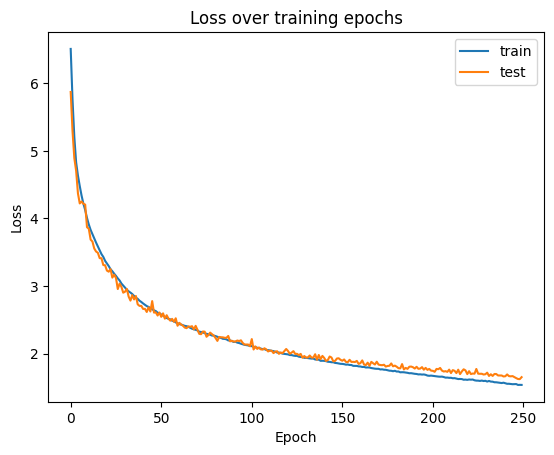

In [114]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

### Saving the model

Let's store the model for later use:

In [1]:
# MODEL_PATH = 'model/model_AE_100u_v1.pth'

# torch.save(model, MODEL_PATH)

### Saving a history to file

In [2]:
# import pickle

# # save dictionary to person_data.pkl file
# with open('history/model_AE_100u_v1.pkl', 'wb') as fp:
#     pickle.dump(history, fp)
#     print('History dictionary saved successfully to file')

### Load Model

Uncomment the next lines, if you want to download and load the pre-trained model:

In [33]:
model = torch.load('./model/model_AE_100u_v1.pth')
model = model.to(device)

### Load History

In [35]:
import pickle

# Read dictionary pkl file
with open('history/model_AE_100u_v1.pkl', 'rb') as fp:
    history = pickle.load(fp)
    print('History dictionary')
    print(history.keys())

History dictionary
dict_keys(['train', 'val'])


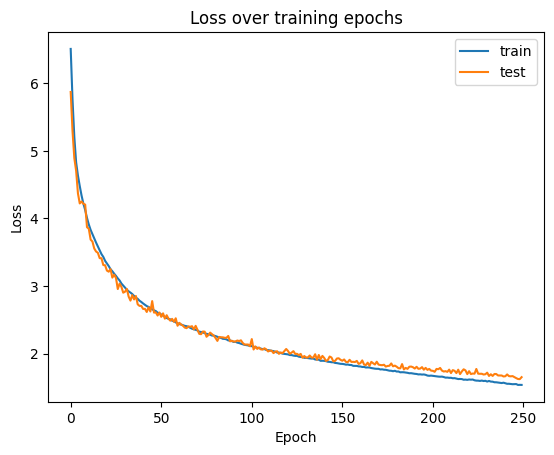

In [36]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

### Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [37]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

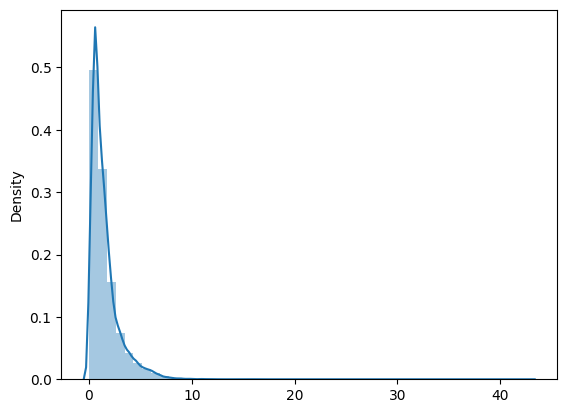

In [38]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [39]:
THRESHOLD = 10

### Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

* If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
* Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal energy consumption

Let's check how well our model does on normal datasets. We'll use the normal datasets from the test set (our model haven't seen those):

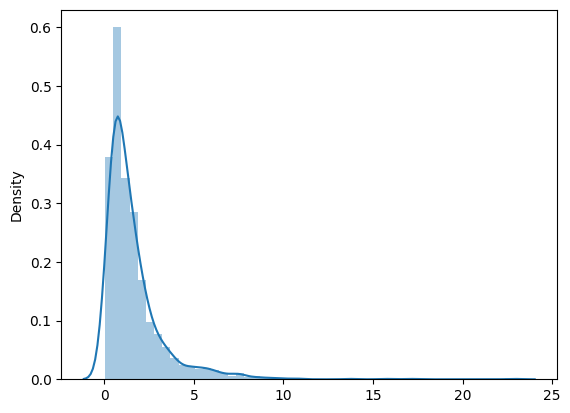

In [40]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [41]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 1566/1572


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal datasets:

We can add this type of theif attacks

In [42]:
# anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

In [43]:
# predictions, pred_losses = predict(model, anomaly_dataset)
# sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [71]:
predictions, pred_losses = predict(model, [test_normal_dataset[21]])

In [72]:
print(len(test_normal_dataset[21]))

96


In [83]:
mse = np.abs(test_normal_dataset[21] - predictions[0])
mse.shape

torch.Size([96, 96])

In [100]:
test_normal_dataset[21].T[0].shape

torch.Size([96])

In [101]:
mse = np.abs(test_normal_dataset[21].T[0] - predictions[0])
mse.shape

torch.Size([96])

In [162]:
def reconstructed_probability(self, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the probability density of the input samples under the learned
        distribution of reconstructed data.
        Args:
            x: Input data tensor of shape (batch_size, num_features).
        Returns:
            A tensor of shape (batch_size,) containing the probability densities of
            the input samples under the learned distribution of reconstructed data.
        """
        with torch.no_grad():
            pred = self.predict(x)
        recon_dist = Normal(pred['recon_mu'], pred['recon_sigma'])
        x = x.unsqueeze(0)
        p = recon_dist.log_prob(x).exp().mean(dim=0).mean(dim=-1)  # vector of shape [batch_size]
        return p

In [159]:
from scipy.stats import norm
# Fit a normal distribution to the data:
mu, std = norm.fit(test_normal_dataset[21].T[0])

In [161]:
print(mu)
print(std)

0.15803124
0.08255976


https://github.com/hupili/python-for-data-and-media-communication-gitbook/issues/118

### Probability Reconstruction Loss
https://github.com/Michedev/VAE_anomaly_detection/blob/master/model/VAE.py

[]

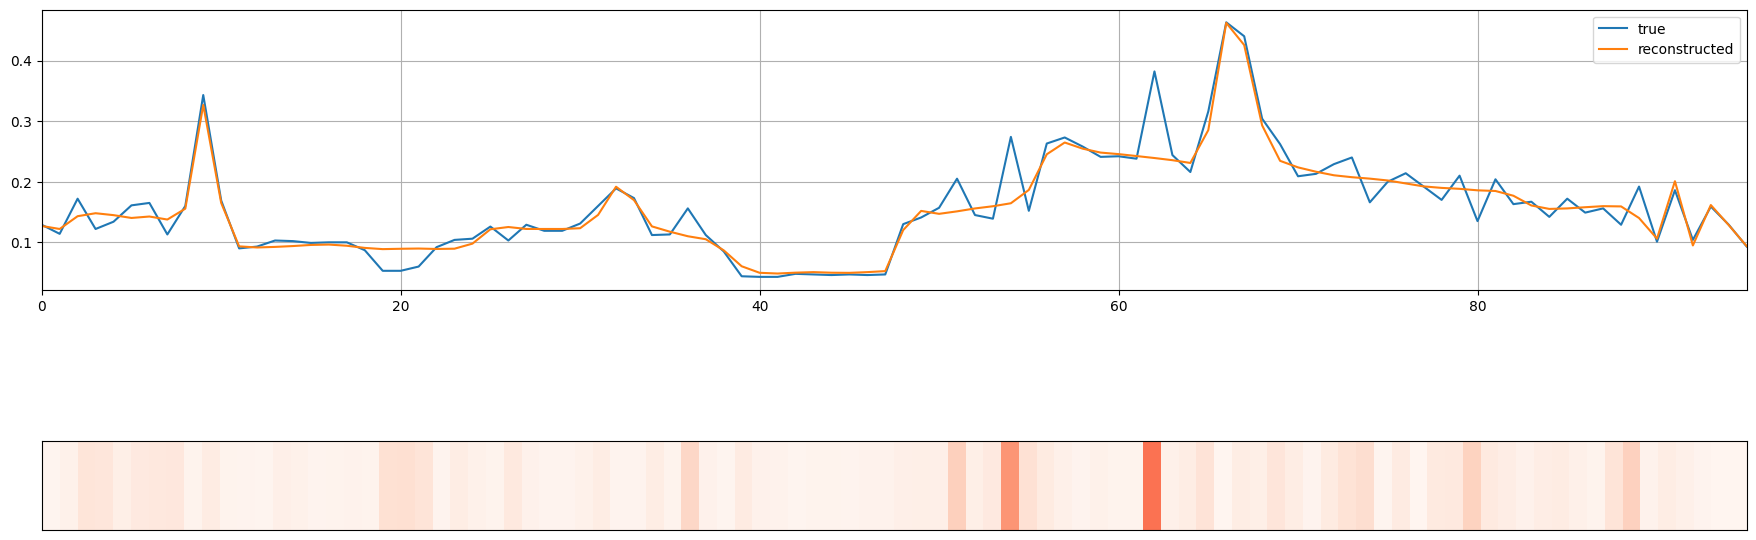

In [158]:
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(
  nrows=2,
  ncols=1,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

predictions, pred_losses = predict(model, [test_normal_dataset[21]])

mse = np.abs(test_normal_dataset[21].T[0] - predictions[0])

ax[0].plot(test_normal_dataset[21], label='true')
ax[0].plot(predictions[0], label='reconstructed')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlim(0, len(test_normal_dataset[21])-1)

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['lime', 'crimson'])
# ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Wistia', vmin=0, vmax=0.1)
ax[1].imshow(np.atleast_2d(mse), aspect=5, cmap='Reds', vmin=0, vmax=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])

# plt.tight_layout();

In [56]:
# [test_normal_dataset[0]]

In [44]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    
    # ax[1].imshow(np.atleast_2d(pred_losses), aspect=5, cmap='Wistia')
    # ax[1].set_xticks([])
    # ax[1].set_yticks([])
    
    ax.legend()

In [45]:
# def plot_prediction(data, model, title, ax):
#     predictions, pred_losses = predict(model, [data])
#     pos = int(len(data)-1)
#     se = np.square(data - predictions[0])
#     se = se[:, pos]

#     ax.plot(data, label='true')
#     ax.plot(predictions[0], label='reconstructed')
#     ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')

#     ax.imshow(np.atleast_3d(se).T, aspect=5, cmap='Wistia')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.legend()

In [46]:
# from matplotlib.colors import LinearSegmentedColormap
# def plot_prediction(data, model, title, ax):
#     predictions, pred_losses = predict(model, [data])
#     pos = int(len(data)-1)
#     se = np.square(data - predictions[0])
#     se = se[:, pos]

#     ax1 = ax[0]
#     ax1.plot(data, label='true')
#     ax1.plot(predictions[0], label='reconstructed')
#     ax1.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
#     ax1.legend()
#     ax1.set_xlim(0, len(data))
    
#     # rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
#     ax2 = ax[1]
#     im = ax2.imshow(np.atleast_3d(se).T, aspect=5, cmap='Wistia')
#     ax2.set_xticks([])
#     ax2.set_yticks([])
#     # fig.colorbar(im, ax=ax2)
#     return ax1, ax2

In [47]:
# fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# plot_prediction(data, model, title='Prediction', ax=axs)
# plt.tight_layout()
# plt.show()

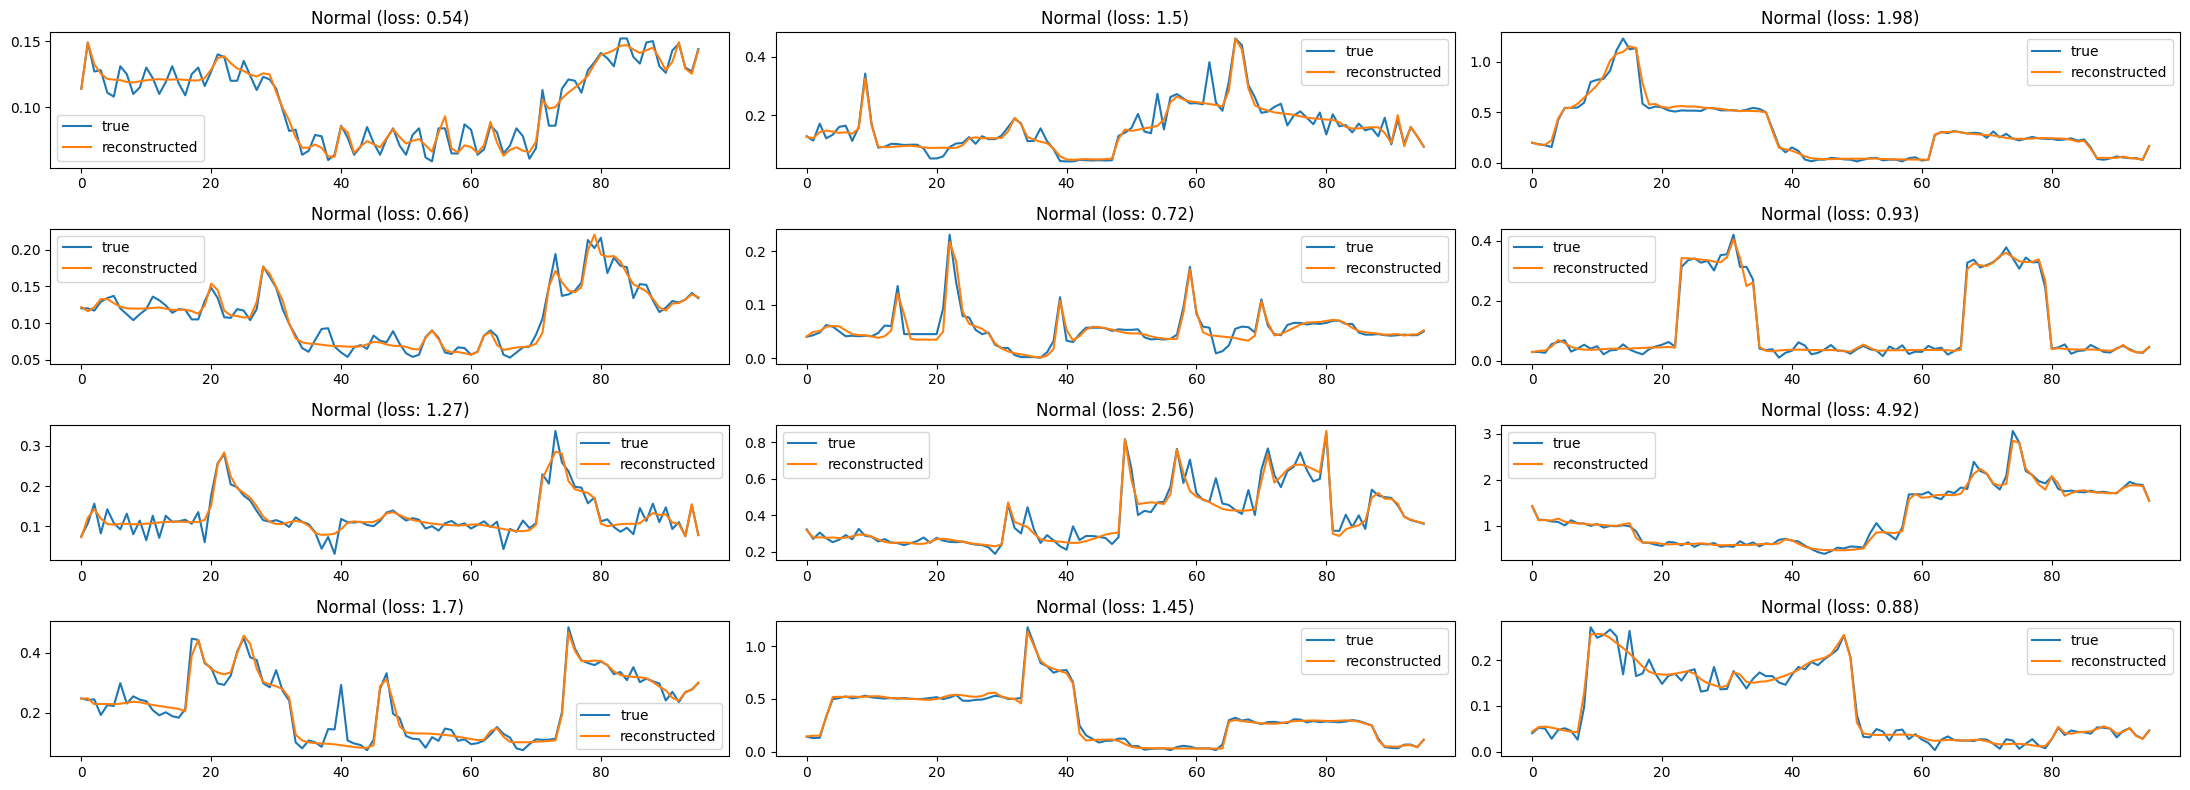

In [48]:
fig, axs = plt.subplots(
  nrows=4,
  ncols=3,
  # sharey=True,
  # sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[20:23]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])
    
for i, data in enumerate(test_normal_dataset[23:26]):
    plot_prediction(data, model, title='Normal', ax=axs[1, i])
    
for i, data in enumerate(test_normal_dataset[26:29]):
    plot_prediction(data, model, title='Normal', ax=axs[2, i])
    
for i, data in enumerate(test_normal_dataset[29:32]):
    plot_prediction(data, model, title='Normal', ax=axs[3, i])

plt.tight_layout()

In [116]:
predictions, pred_losses = predict(model, test_normal_dataset)

In [117]:
true = test_normal_dataset.squeeze().numpy()

AttributeError: 'list' object has no attribute 'squeeze'

In [111]:
se = np.square(test_normal_dataset.squeeze().numpy() - predictions)[:, 95]

AttributeError: 'list' object has no attribute 'squeeze'

In [110]:
test_normal_dataset[0].squeeze().numpy()

array([0.026, 0.044, 0.031, 0.021, 0.021, 0.041, 0.023, 0.029, 0.026,
       0.045, 0.027, 0.023, 0.022, 0.054, 0.039, 0.031, 0.027, 0.053,
       0.037, 0.029, 0.028, 0.046, 0.037, 0.027, 0.028, 0.043, 0.041,
       0.023, 0.027, 0.039, 0.048, 0.026, 0.025, 0.036, 0.052, 0.027,
       0.024, 0.038, 0.051, 0.028, 0.026, 0.043, 0.046, 0.028, 0.031,
       0.048, 0.041, 0.041, 0.057, 0.059, 0.041, 0.045, 0.065, 0.056,
       0.041, 0.043, 0.059, 0.036, 0.028, 0.053, 0.048, 0.03 , 0.038,
       0.055, 0.036, 0.029, 0.059, 0.076, 0.057, 0.066, 0.076, 0.051,
       0.045, 0.067, 0.064, 0.051, 0.053, 0.069, 0.07 , 0.064, 0.065,
       0.044, 0.039, 0.061, 0.044, 0.031, 0.037, 0.053, 0.034, 0.035,
       0.039, 0.054, 0.034, 0.031, 0.038, 0.045], dtype=float32)

In [1]:
# predictions

### Test

## 5. Evaluate the model using the test set

# Task

### VAE autocoder
* https://www.google.com/search?q=variational+autoencoder+based+anomaly+detection+using+reconstruction+probability+github&rlz=1C5CHFA_enTH999TH999&oq=Variational+Autoencoder+based+Anomaly+Detection+using+Reconstruction+Probability+&aqs=chrome.1.69i57j0i512j69i60.3070j0j7&sourceid=chrome&ie=UTF-8
* https://github.com/Michedev/VAE_anomaly_detection
* https://github.com/smile-yan/vae-anomaly-detection
* https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py


### CNN
* https://github.com/khanmhmdi/Cifar-Image-Reconstruction-using-Autoencoder-Models/blob/main/Image_reconstruction.ipynb
* https://github.com/ebrahimpichka/conv-autoencoder (test on this now!!)